<a href="https://colab.research.google.com/github/PieroPastor/sparse-multiplication/blob/main/sparse_matrix_multiplication_traditional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import time
import ctypes
import numpy as np
import scipy.sparse as sp
from itertools import repeat
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [ ]:
def compressed_sparse_row(x):
  compressed = []
  row_pointer = []
  flag = True
  for i in range(len(x)):
    for j in range(len(x[i])):
      if x[i][j] != 0:
        if flag:
          row_pointer.insert(len(row_pointer), len(compressed))
          flag = False
        compressed.insert(len(compressed), [i, j, x[i][j]])
    flag = True
  compressed = np.array(compressed)
  return np.array(row_pointer).astype(np.float32), np.array(compressed[:, 0]).astype(np.float32), np.array(compressed[:, 1]).astype(np.float32), np.array(compressed[:, 2]).astype(np.float32)

In [ ]:
def decompressed_sparse_row(row, col, val):
  sparse_new = np.zeros((int(max(row))+1, int(max(col))+1)).astype(np.float32)
  counter = 0
  for i in range(int(max(row))+1):
    for j in range(int(max(col))+1):
      if counter < len(row) and i == row[counter] and j == col[counter]:
        sparse_new[i][j] = val[counter]
        counter += 1
  return sparse_new

In [ ]:
def matriz_vector(row, col, val, vector):
  sol = np.zeros(len(row)).astype(np.float32)
  for i in range(len(row)-1):
    for j in range(int(row[i]), int(row[i+1])): #Se usa como tope el siguiente puntero
      sol[i] += val[j] * vector[int(col[j])]
  for i in range(int(row[len(row)-1]), len(col)): #Se itera especialmente para el último puntero
    sol[len(row)-1] += val[i] * vector[int(col[i])]
  return sol

In [ ]:
def matriz_vector_multiprocessing_sub(ini, fin, row, len_rep, col, val, vector):
  sol = np.zeros(len_rep).astype(np.float32) #fin-ini por la cantidad de filas que habrá
  for i in range(ini, fin-1): #Repite tantas filas hay por proceso
    if i-ini >= len_rep-1: break
    for j in range(int(row[i]), int(row[i+1])): #Itera cuantos datos diferentes a cero haya en la fila ahorrando iteraciones innecesarias
      sol[i-ini] += val[j] * vector[int(col[j])]
  if fin <= len(row)-1: max = int(row[fin]) #Compara para saber si se encuentra en el último puntero global o no, y así enviar su respecitvo fin de bucle
  else:
    max = len(col)
    fin = len(row)
  for i in range(int(row[fin-1]), max):
    sol[len_rep-1] += val[i] * vector[int(col[i])]
  return sol

def matriz_vector_multiprocessing(row, col, val, vector):
  cpus = os.cpu_count()
  chunk = 1
  if cpus > (len(row)): cpus = (len(row)) #Si hay más procesadores que procesos necesarios, entonces se recorta
  else: chunk = math.ceil((len(row))/cpus) #Si hay menos, se divide en tantos procesos como procesadores y un chunk es un grupo de datos
  cpus = int(cpus)
  p = Pool(processes=cpus) #Inicializa el pool para multiprocessing
  args = zip((i*chunk for i in range(cpus)), #Argumento del índice donde empieza el proceso
             ((i+1)*chunk for i in range(cpus)), #Argumento del índice donde acaba el proceso
             repeat(row),
             (len(row[i*chunk:(i+1)*chunk]) for i in range(cpus)),
             repeat(col),
             repeat(val),
             repeat(vector))
  resultado = p.starmap(matriz_vector_multiprocessing_sub, args)
  return np.concatenate(resultado)

In [ ]:
%%file matriz_vector_simd.asm
section .text
    global matriz_vector_simd
;rdi <- row
;rsi <- col
;rdx <- val
;rcx <- vector
;r8 <- sol
;r9 <- n_ptrs, n
;Se tiene un algoritmo que mezcla SIMD y al mismo tiempo operaciones normales para ciertas operaciones, ya que, no se puede predecir cuantos valores
;diferente de cero habrá en cada columna de la matriz.
matriz_vector_simd:
    movss xmm1, [r9 + 4] ;Guarda n en xmm1 ya que se mandó como doubles y se debe de convertir
    movss xmm0, [r9] ;Guarda n_ptrs
    cvtss2si r9, xmm0 ;Los convierte a enteros
    cvtss2si r10, xmm1
    dec r9 ;Le resta uno porque el bucle es hasta n_ptrs-1
    mov r12, 0 ;Valor de i
    cmp r12, r9
    jl bucle1
ret

bucle1:
    xorps xmm0, xmm0 ;Se limpian todos los registros para evitar fallos en las operaciones
    xorps xmm1, xmm1
    xorps xmm2, xmm2
    xorps xmm3, xmm3
    xorps xmm4, xmm4
    movss xmm15, [rdi + r12*4] ;Pasa la información del puntero a fila y la pasa a entero
    cvtss2si r13, xmm15
    movss xmm15, [rdi + r12*4 + 4] ;Pasa el siguiente puntero a fila como tope y lo pasa a entero
    cvtss2si r14, xmm15
    cmp r13, r14
    push r12
    jl bucle2
    jmp fin_bucle2

bucle2:
    push r13 ;Guarda el contador r13, ya que, se necesitan más registros
    mov r12, r14
    sub r12, r13
    mov rax, r12
    cmp r12, 4 ;Para ver si faltan menos de 4 manda especial, es decir, usará los registros xmmx como cola y almacenará la información ahí hasta donde haya
    jl enviar_especial
    mov r12, 4
    movups xmm1, [rdx + r13*4] ;Manda cuatro valores con una sola operacion
    movups xmm2, [rsi + r13*4]
    mov r13, r12
    jmp guardar_datos_vector

enviar_especial:
    xorps xmm4, xmm4 ;Lo almacena de esa forma para también poder operar con mulps, ya que, como los sobrantes es cero no hay problema y aún se ahorra tiempo
    movss xmm4, [rdx + r13*4] ;Se necesita el auxiliar porque el movss cuando se trabaja con un puntero limpia todo el registro, por lo que la cola se borra
    movss xmm1, xmm4
    movss xmm4, [rsi + r13*4]
    movss xmm2, xmm4
    shufps xmm1, xmm1, 00111001b ;Envía el valor guardado al final y el siguiente para guardarlo ahí (una cola)
    shufps xmm2, xmm2, 00111001b
    dec r12
    inc r13
    cmp r12, 0 ;Hasta que se ingrese la cantidad de data que haya
    jg enviar_especial
    mov rbx, 4 ;Para mantener todo alineado y operar correctamente se deben de completar las vueltas a la cola por lo que la diferencia con 4 es la cantidad de vueltas que faltan.
    sub rbx, rax
    jmp organizar_especial

organizar_especial:
    shufps xmm1, xmm1, 00111001b ;Realiza solo vueltas para alinear los datos
    shufps xmm2, xmm2, 00111001b
    dec rbx
    cmp rbx, 0
    jg organizar_especial
    mov r13, rax
    mov r12, rax
    jmp guardar_datos_vector

guardar_datos_vector:
    cvtss2si r15, xmm2 ;Realiza la misma lógica para guardar todos los datos necesarios del vector en un registro y así operarlo junto aprovechando el SIMD
    movss xmm4, [rcx + r15*4]
    movss xmm3, xmm4
    shufps xmm2, xmm2, 00111001b ;Pasa a la siguiente columna
    shufps xmm3, xmm3, 00111001b ;Para guardar el siguiente dato de vector
    dec r12
    cmp r12, 0
    jg guardar_datos_vector
    mov r12, 4
    sub r12, r13
    cmp r13, 4 ;En caso haya habido menos de 4 valores también se tendrán que alinear los datos
    jl organizar_datos
    jmp fin_bucle2

organizar_datos:
    shufps xmm3, xmm3, 00111001b
    shufps xmm2, xmm2, 00111001b
    dec r12
    cmp r12, 0
    jg organizar_datos
    jmp fin_bucle2

fin_bucle2:
    pop r13 ;Regresa r13 a la normalidad
    mulps xmm3, xmm1 ;Multiplica los datos del vector y la matriz y los suma entre ellos
    haddps xmm3, xmm3
    haddps xmm3, xmm3
    addss xmm0, xmm3 ;Se agrega al sumador
    add r13, 4 ;Se suma cuatro porque se avanzo esa cantidad si o si
    xorps xmm1, xmm1 ;Se limpian los registros
    xorps xmm2, xmm2
    xorps xmm3, xmm3
    cmp r13, r14
    jl bucle2
    pop r12 ;Se retira r12 para usarlo y guardar en soluciones el xmm0
    movss [r8 + r12*4], xmm0
    inc r12
    cmp r10, -1 ;Se tiene esta bandera especial para poder usar el código desde otro punto fuera del bucle principal
    je fin_algoritmo
    cmp r12, r9
    jl bucle1
    jmp segunda_parte

segunda_parte:
    movss xmm15, [rdi + r9*4] ;Como falta el valor para n_ptrs porque se evitó, se setean los registros y se salta al bucle2 como si fuera una función
    xorps xmm0, xmm0
    cvtss2si r13, xmm15 ;Pasa el [n_ptrs-1]
    mov r14, r10 ;El final es la cantidad de columnas
    mov r12, r9
    push r12 ;Guarda r12 más que nada por el futuro popeo y que así el PC se mantenga intacto y pueda retornar
    mov r10, -1 ;Servirá como una bandera
    xorps xmm0, xmm0
    xorps xmm1, xmm1
    xorps xmm2, xmm2
    xorps xmm3, xmm3
    xorps xmm4, xmm4
    jmp bucle2

fin_algoritmo:
    ret

Overwriting matriz_vector_simd.asm


In [ ]:
! nasm -f elf64 matriz_vector_simd.asm -o matriz_vector_simd.o

In [ ]:
%%file matriz_vector.c
extern void matriz_vector_simd(float *row, float *col, float *val, float *vector, float *sol, float *tam);
void matriz_vector(float *row, float *col, float *val, float *vector, float *sol, int n_ptrs, int n){
    for(int i=0; i < n_ptrs-1; i++){
        for(int j=(int)row[i]; j < (int)row[i+1]; j++) sol[i] += val[j] * vector[(int)col[j]];
    }
    for(int i=(int)row[n_ptrs-1]; i < n; i++) sol[n_ptrs-1] += val[i] * vector[(int)col[i]];
    return;
}

Overwriting matriz_vector.c


In [ ]:
! gcc -shared -fPIC matriz_vector_simd.o matriz_vector.c -o matriz_vector.so

In [ ]:
def matriz_vector_c(row, col, val, vector):
  sol = np.zeros(len(row),).astype(np.float32)
  lib = ctypes.CDLL('./matriz_vector.so')
  lib.matriz_vector.argtypes = [np.ctypeslib.ndpointer(dtype = np.float32),
                                np.ctypeslib.ndpointer(dtype = np.float32),
                                np.ctypeslib.ndpointer(dtype = np.float32),
                                np.ctypeslib.ndpointer(dtype = np.float32),
                                np.ctypeslib.ndpointer(dtype = np.float32),
                                ctypes.c_int, ctypes.c_int]
  lib.matriz_vector(row, col, val, vector, sol, len(row), len(col))
  return sol

In [ ]:
def matriz_vector_simd(row, col, val, vector):
  sol = np.zeros(len(row),).astype(np.float32)
  lib = ctypes.CDLL('./matriz_vector.so')
  lib.matriz_vector_simd.argtypes = [np.ctypeslib.ndpointer(dtype = np.float32),
                                     np.ctypeslib.ndpointer(dtype = np.float32),
                                     np.ctypeslib.ndpointer(dtype = np.float32),
                                     np.ctypeslib.ndpointer(dtype = np.float32),
                                     np.ctypeslib.ndpointer(dtype = np.float32),
                                     np.ctypeslib.ndpointer(dtype = np.float32)]
  lib.matriz_vector_simd(row, col, val, vector, sol, np.array([np.int32(len(row)), np.int32(len(col))]).astype(np.float32))
  return sol

In [ ]:
def calcular_tiempo(iteraciones, row, col, val, vector, funcion):
  times = np.zeros(iteraciones).astype(np.float32)
  for i in range(iteraciones):
    tic = time.perf_counter()
    resultado = funcion(row, col, val, vector)
    toc = time.perf_counter()
    times[i] = toc-tic
  return np.median(times)

In [ ]:
def probar_algoritmos(m, n):
  vector = np.random.uniform(low=0, high=10, size=(n, )).astype(np.float32)
  sparse = sp.random(m, n, density=0.2, format='csr', dtype=np.float32).toarray()
  sparse *= 10 #Consigue datos entre [0, 10[
  row_ptr, row, col, val = compressed_sparse_row(sparse)
  t_sec = calcular_tiempo(15, row_ptr, col, val, vector, matriz_vector)
  t_mul = calcular_tiempo(15, row_ptr, col, val, vector, matriz_vector_multiprocessing)
  t_c = calcular_tiempo(15, row_ptr, col, val, vector, matriz_vector_c)
  t_smd = calcular_tiempo(15, row_ptr, col, val, vector, matriz_vector_simd)
  print(f"SECUENCIAL: {t_sec} | MULTIPROCESSING: {t_mul} | C: {t_c} | SIMD: {t_smd} \n")
  times = [t_sec, t_mul, t_c, t_smd]
  nombres = ["SECUENCIAL", "MULTIPROCESSING", "C", "SIMD"]
  plt.plot(nombres, times, 'g-')
  plt.title(f"Mediana de tiempos (s) para {m}x{n} = {m*n} datos.")
  plt.xlabel('ALGORITMO')
  plt.ylabel('TIEMPO(s)')
  plt.grid(True)
  plt.show()

In [ ]:
m = 4
n = 4
vector = np.random.uniform(low=0, high=10, size=(n, )).astype(np.float32)
sparse = sp.random(m, n, density=0.2, format='csr', dtype=np.float32).toarray()
sparse *= 10 #Consigue datos entre [0, 10[
row_ptr, row, col, val = compressed_sparse_row(sparse)
print(row_ptr, col, val)
print(sparse)
sparse_new = decompressed_sparse_row(row, col, val)
print(sparse_new)
print("Vector: ", vector)
multiplicacion = matriz_vector(row_ptr, col, val, vector)
print("Secuencial     : ", multiplicacion)
resultado = matriz_vector_multiprocessing(row_ptr, col, val, vector)
print("Multiprocessing: ", resultado)
resultado_c = matriz_vector_c(row_ptr, col, val, vector)
print("C              : ", resultado_c)
resultado_simd = matriz_vector_simd(row_ptr, col, val, vector)
print("SIMD           : ", resultado_simd)

[0. 1. 2.] [1. 1. 2.] [6.7374616  8.374479   0.38030493]
[[0.         6.7374616  0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         8.374479   0.         0.        ]
 [0.         0.         0.38030493 0.        ]]
[[0.         6.7374616  0.        ]
 [0.         0.         0.        ]
 [0.         8.374479   0.        ]
 [0.         0.         0.38030493]]
Vector:  [6.696605 9.840538 3.223361 2.524409]
Secuencial     :  [66.30025   82.409386   1.2258601]
Multiprocessing:  [66.30025   82.409386   1.2258601]
C              :  [66.30025   82.409386   1.2258601]
SIMD           :  [66.30025   82.409386   1.2258601]


SECUENCIAL: 0.00010021799971582368 | MULTIPROCESSING: 0.06302415579557419 | C: 0.0002999079879373312 | SIMD: 0.000243492002482526 



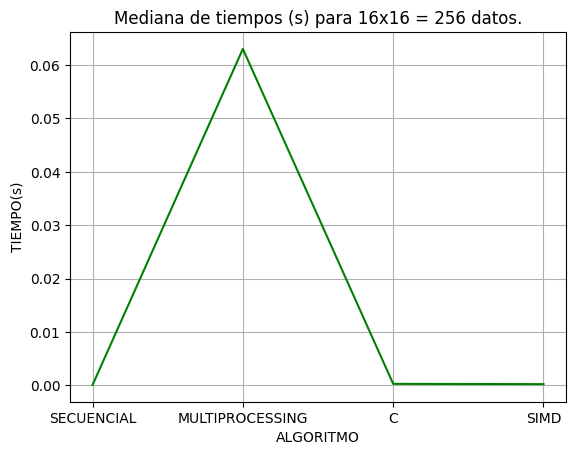

SECUENCIAL: 0.015447440557181835 | MULTIPROCESSING: 0.10686905682086945 | C: 0.0003606730024330318 | SIMD: 0.00027572200633585453 



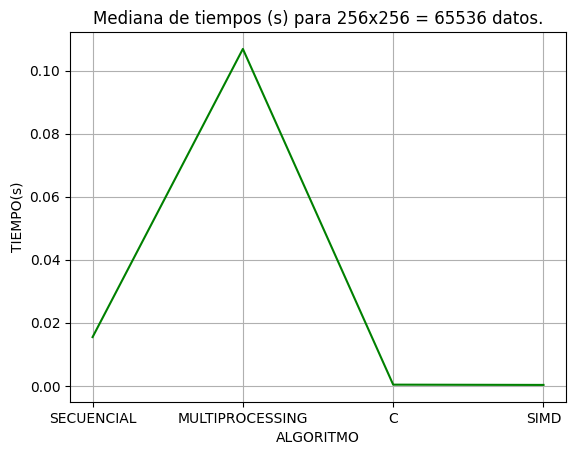

SECUENCIAL: 3.188835620880127 | MULTIPROCESSING: 2.5373871326446533 | C: 0.031173892319202423 | SIMD: 0.013316075317561626 



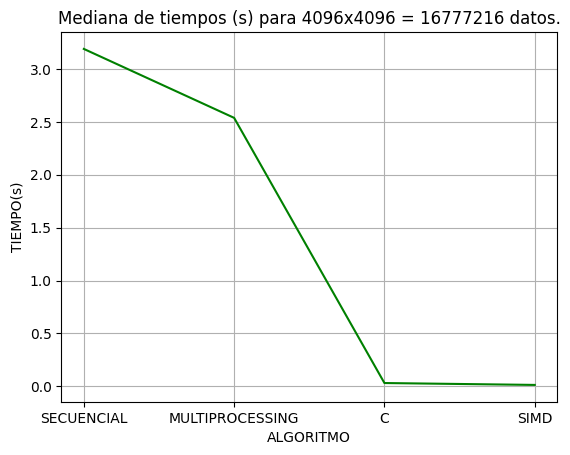

MemoryError: Unable to allocate 32.0 GiB for an array with shape (4294967296,) and data type int64

In [ ]:
probar_algoritmos(2**4, 2**4)
probar_algoritmos(2**8, 2**8)
probar_algoritmos(2**12, 2**12)
probar_algoritmos(2**16, 2**16)

Fue un problema interesante, ya que, la incertidumbre de saber cuantos valores en las columnas son relevantes obligaba a desarrollar funciones genéricas y no únicamente para tamaños múltiplo de 4. Con respecto a los tiempos de ejecución se notó claramente que el SIMD es superior a todos, no obstante se encuentra ligeramente cerca con la secuencialidad de C, aunque, no se pudieron concretar todas las pruebas porque la cantidad de datos era mayor a lo permitido por la ram (se aprecia en el error luego del último gráfico), así que con lo que se tiene, se concluye que SIMD es el más veloz, casi igual con C. Por último, el multiprocessing con este algoritmo no es muy eficiente a nivel espacial, ya que, como se utiliza un arreglo de punteros a las filas, se tiene que usar constantemente el tamaño completo de las columnas y valores (esto porque los punteros apuntan a los índices en los arreglos), la ineficiencia está en la copia constante de los arreglos. </p>
SIMD es más rápido que la secuencialidad de C, porque optimiza el número de instrucciones, por ejemplo, todo se reduce a una única multiplicación y solo dos sumas, además en ciertos casos se simplifica la lectura de datos a sola una instrucción, en lugar de mover constantemente y leer de memoria cada que se necesite información. </p>
Con respecto a multiprocessing y la secuencialidad en Python, la optimización se encuentra en el envío de iteraciones a la cantidad de núcleos que tenga el cpu, no obstante, esto es lo máximo que se puede paralelizar, ya que, si se envían más procesos que núcleos, entonces perderá eficiencia y tardará incluso más que al trabajar con menor cantidad de procesadores; esto sucede porque se comienza a trabajar secuencialmente el envío a cada núcleo, volviendo más compleja la ejecución y así aumentando su tiempo.